# Looking at the disparity between the 2016 EU referendum and the 2017 General Election votes

Following discussions in work over a belief that Labour wouldn't call for a second referendum due to the precarious fact that Labour voting areas voted overwhelmingly Leave, and any moves to remain would destroy their voter base I thought it would be good to look into this.

In [577]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import urllib.request

%matplotlib inline

In [496]:
# Set the colours for Remain and Leave groups
colour_remain = (0/255, 107/255, 176/255)
colour_leave = (255/255, 190/255, 71/255)

The first issue is that the EU referendum results were not delived by constituency, but rather 'Voting area'. Fortunately some local authorities did publish results by both constituency and voting area, and from this analysts have modelled the vote distributions and produced an estimate for each constituencies EU referendum vote proprotion.

This EU referendum constituency vote share data can be found at https://commonslibrary.parliament.uk/wp-content/uploads/2017/02/eureferendum_constitunecy.xlsx

In [48]:
('https://commonslibrary.parliament.uk/wp-content/uploads/2017/02/eureferendum_constitunecy.xlsx')

EU_ref_data = pd.read_excel('eureferendum_constitunecy.xlsx',
                            sheet_name = 'DATA',
                            skiprows = 7,
                            usecols = 'B,C,G',
                            names = ['ONS Code', 'Constituency', 'Leave proportion']
                           )

EU_ref_data.head()

,ONS Code,Constituency,Leave proportion
0,E14000582,Boston and Skegness,0.756499
1,E14001011,Walsall North,0.741852
2,E14000642,Clacton,0.730440
3,E14000933,South Basildon and East Thurrock,0.729956
4,E14000771,Kingston upon Hull East,0.728316


General election data is much simpler to obtain and this data can be found at https://www.electoralcommission.org.uk/__data/assets/excel_doc/0007/234979/2017-UKPGE-Electoral-Data.xls

In [540]:
GE_data = pd.read_excel('2017-UKPGE-Electoral-Data.xls',
                       sheet_name = 'Results',
                       skiprows = 1,
                       usecols = 'A,C,G,H')

GE_data.head()

,ONS Code,Constituency,Party Identifer,Valid votes
0,E14000530,Aldershot,Green Party,1090
1,E14000530,Aldershot,UKIP,1796
2,E14000530,Aldershot,Liberal Democrats,3637
3,E14000530,Aldershot,Labour,15477
4,E14000530,Aldershot,Conservative,26950


Now that we have our two datasets we need to combine them into one dataset. From our two datasets we can see that they share two fields `ONS Code` and `Constituency`. While I don't imagine there would be any differences in how the entries in the `Constituency` field are formatted, it will be a lot safer to use the `ONS Code` field as there is little room for creative difference in this field.

With that in mind, we can use the `merge` function from `pandas` to combine our two datasets, using the `ONS Code` to match up entries.

In [547]:
combined_data = pd.merge(GE_data, 
                         EU_ref_data, 
                         on = 'ONS Code')

combined_data.head()

,ONS Code,Constituency_x,Party Identifer,Valid votes,Constituency_y,Leave proportion
0,E14000530,Aldershot,Green Party,1090,Aldershot,0.578978
1,E14000530,Aldershot,UKIP,1796,Aldershot,0.578978
2,E14000530,Aldershot,Liberal Democrats,3637,Aldershot,0.578978
3,E14000530,Aldershot,Labour,15477,Aldershot,0.578978
4,E14000530,Aldershot,Conservative,26950,Aldershot,0.578978


Ok, so we can see that everything is lining up nicely here now, so let's tidy up our database by removing the unneeded column and fixing those headings

In [548]:
combined_data = combined_data.drop(columns = ['Constituency_y'])

combined_data.rename(columns={'Constituency_x': 'Constituency'}, inplace=True)

In [549]:
combined_data.head()

,ONS Code,Constituency,Party Identifer,Valid votes,Leave proportion
0,E14000530,Aldershot,Green Party,1090,0.578978
1,E14000530,Aldershot,UKIP,1796,0.578978
2,E14000530,Aldershot,Liberal Democrats,3637,0.578978
3,E14000530,Aldershot,Labour,15477,0.578978
4,E14000530,Aldershot,Conservative,26950,0.578978


Now lets remove all those losing parties, by only keeping the party with the highest number of `Valid votes` for each `ONS Code`.

In [550]:
# https://stackoverflow.com/questions/15705630/python-getting-the-row-which-has-the-max-value-in-groups-using-groupby
idx = combined_data.groupby(['ONS Code'])['Valid votes'].transform(max) == combined_data['Valid votes']
consolidated_data = combined_data[idx]

consolidated_data.head()

,ONS Code,Constituency,Party Identifer,Valid votes,Leave proportion
4,E14000530,Aldershot,Conservative,26950,0.578978
8,E14000531,Aldridge-Brownhills,Conservative,26317,0.677963
13,E14000532,Altrincham and Sale West,Conservative,26933,0.385878
18,E14000533,Amber Valley,Conservative,25905,0.652991
23,E14000534,Arundel and South Downs,Conservative,37573,0.497011


Now a final tidy of the dataframe, removing the `Valid vote` field as it's no longer required, and giving the parties the winners title that they deserve.

In [551]:
consolidated_data.rename(columns={'Party Identifer' : 'Winning Party'}, inplace=True)
consolidated_data = consolidated_data.drop(columns = ['Valid votes'])

consolidated_data.head()

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,ONS Code,Constituency,Winning Party,Leave proportion
4,E14000530,Aldershot,Conservative,0.578978
8,E14000531,Aldridge-Brownhills,Conservative,0.677963
13,E14000532,Altrincham and Sale West,Conservative,0.385878
18,E14000533,Amber Valley,Conservative,0.652991
23,E14000534,Arundel and South Downs,Conservative,0.497011


One final sanity check to ensure we have the correct number of constituencies (remember there were 650 constituencies in the UK in 2017).

In [553]:
len(consolidated_data['Constituency'].unique())

650

### Finding the result for a particular constituency based on name

https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

In [530]:
consolidated_data[consolidated_data['Constituency'].str.contains('Stoke')]

,ONS Code,Constituency,Winning Party,Leave proportion
883,E14000702,Filton and Bradley Stoke,Conservative,0.487730
980,E14000720,Hackney North and Stoke Newington,Labour,0.204808
2278,E14000972,Stoke-on-Trent Central,Labour,0.648466
2282,E14000973,Stoke-on-Trent North,Labour,0.721236
2286,E14000974,Stoke-on-Trent South,Conservative,0.711074


In [244]:
consolidated_data['Winning Party'].unique()

array(['Conservative', 'Labour', 'Liberal Democrats', 'Green Party',
       'Speaker', 'DUP', 'Sinn Féin', 'Independent', 'SNP', 'Plaid Cymru'],
      dtype=object)

In [531]:
consolidated_data[consolidated_data['Winning Party'].isin(['Liberal Democrats'])]

,ONS Code,Constituency,Winning Party,Leave proportion
92,E14000547,Bath,Liberal Democrats,0.317245
459,E14000621,Carshalton and Wallington,Liberal Democrats,0.562612
790,E14000684,Eastbourne,Liberal Democrats,0.575445
1252,E14000770,Kingston and Surbiton,Liberal Democrats,0.408445
1655,E14000848,North Norfolk,Liberal Democrats,0.584003
1784,E14000874,Oxford West and Abingdon,Liberal Democrats,0.380292
2439,E14001005,Twickenham,Liberal Democrats,0.333159
2594,E14001037,Westmorland and Lonsdale,Liberal Democrats,0.470562
2860,S14000009,"Caithness, Sutherland and Easter Ross",Liberal Democrats,0.513394
2900,S14000018,East Dunbartonshire,Liberal Democrats,0.268682


## Looking at the breakdown on Remain/Leave by constituency

First let's look at the number of remain (`Leave proportion < 50%`) and leave (`Leave proportion >= 50%`) constituencies across the UK as a whole.

In [555]:
remain_count = consolidated_data[consolidated_data['Leave proportion'] < 0.5].shape[0]
leave_count = consolidated_data[consolidated_data['Leave proportion'] >= 0.5].shape[0]

print('The number of remain constituencies is %3d or %2.2f%% of the constituencies.' % (remain_count, 100*remain_count/(remain_count+leave_count) ) )
print('The number of leave constituencies is %3d or %2.2f%% of the constituencies.' % (leave_count, 100*leave_count/(remain_count+leave_count) ) )

The number of remain constituencies is 241 or 37.08% of the constituencies.
The number of leave constituencies is 409 or 62.92% of the constituencies.


So if the referendum was FPTP, the Leave vote would have had a much more comfortable time of things with over three-fifths of constituencies backing Leave!

With that in mind, let's break things down and look at what party each constituency sent to Parliament the 2017 General Election.

In [556]:
# Define all the unique winning parties in the database
parties = consolidated_data['Winning Party'].unique()

results_list=[]

# Collate the Remain/Leave constituency totals for each party
for party in parties:
    remain = consolidated_data[(consolidated_data['Winning Party'] == party) & ( consolidated_data['Leave proportion'] < 0.5)].shape[0]
    leave = consolidated_data[(consolidated_data['Winning Party'] == party) & ( consolidated_data['Leave proportion'] >= 0.5)].shape[0]
    results_list.append((party, remain, leave, 100*remain/(remain+leave), 100*leave/(remain+leave),100*remain/remain_count, 100*leave/leave_count))
    

# Finally, convert our list to a pandas dataframe, with some useful column headers
results = pd.DataFrame(results_list, 
                       columns = ['Party', 
                                  'Remain constituency count\nfor party', 'Leave constituency count\nfor party', 
                                  'Remain constituency percentage\nfor party', 'Leave constituency percentage\nfor party', 
                                  'Remain constituency percentage of\nnationwide Remain constituencies', 'Leave constituency percentage of\nnationwide Leave constituencies', 
                                 ]
                      )

In [557]:
# A slight ammendement as Sinn Féin uses a unicode character which causes some annoyances later on, I'll overwrite this.
results.at[6, 'Party'] = 'Sinn Fein'

In [ ]:
And another check we haven't lost anyone along the way

In [559]:
results[results.columns[1]].sum() + results[results.columns[2]].sum()

650

Ok then that all looks right! Let's look at how things break down for each party.

In [483]:
results

,Party,Remain constituency count for party,Leave constituency count for party,Remain constituency percentage for party,Leave constituency percentage for party,Remain constituency percentage of nationwide Remain constituencies,Leave constituency percentage of nationwide Leave constituencies
0,Conservative,78,239,24.605678,75.394322,32.365145,58.435208
1,Labour,103,159,39.312977,60.687023,42.738589,38.875306
2,Liberal Democrats,8,4,66.666667,33.333333,3.319502,0.977995
3,Green Party,1,0,100.000000,0.000000,0.414938,0.000000
4,Speaker,1,0,100.000000,0.000000,0.414938,0.000000
5,DUP,4,6,40.000000,60.000000,1.659751,1.466993
6,Sinn Fein,7,0,100.000000,0.000000,2.904564,0.000000
7,Independent,1,0,100.000000,0.000000,0.414938,0.000000
8,SNP,35,0,100.000000,0.000000,14.522822,0.000000
9,Plaid Cymru,3,1,75.000000,25.000000,1.244813,0.244499


Wow! From this you can really see why the Conservatives and Labour are both loathe to nail their colours to the second referendum post with 75 and 60\% of their current constituencies voting to leave the EU in 2016. 

As a party, Labour constituencies have a 10 point swing to favouring Leave, but we can see that Labour are the party that are representing the largest proportion of all the Remain voters.

Right let's visualise these results!

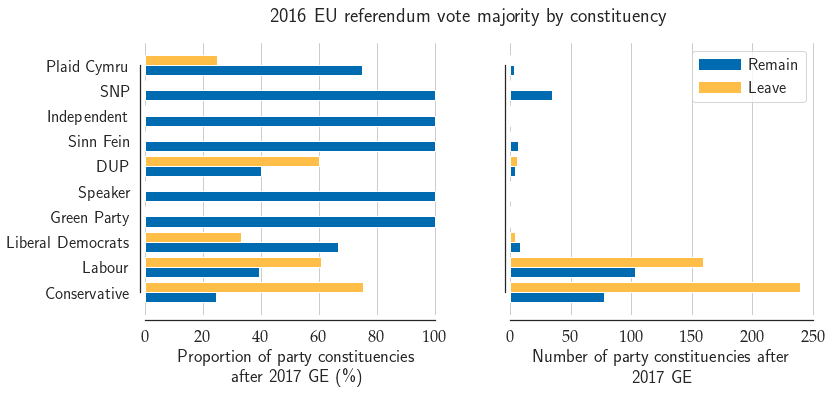

In [576]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(12,5),
                           ncols = 2,
                           sharey=True
                          )

sns.set_style("ticks")
sns.set_context("notebook", 
                font_scale=1.5
               )

index = np.arange(len(parties))
bar_width = 0.4

# Percentage plot (left)

ax[0].barh(index, 
        results[results.columns[3]], 
        bar_width,
        color=colour_remain,
        label='Remain')

ax[0].barh(index+bar_width, 
        results[results.columns[4]], 
        bar_width,
        color=colour_leave,
        label='Leave')

ax[0].set_xlabel('Proportion of party constituencies \nafter 2017 GE (\%)')


# Total plot (right)

ax[1].barh(index, 
        results[results.columns[1]], 
        bar_width,
        color=colour_remain,
        label='Remain')

ax[1].barh(index+bar_width, 
        results[results.columns[2]], 
        bar_width,
        color=colour_leave,
        label='Leave')

ax[1].set_xlabel('Number of party constituencies after \n2017 GE')

ax[1].legend()

# Both plots
for axis in ax:
    axis.set_yticks(index + bar_width / 2)
    axis.set_yticklabels(results[results.columns[0]])
    axis.grid(axis='x')

fig.suptitle('2016 EU referendum vote majority by constituency', fontsize=20)

sns.despine(offset=5,
#           left=True,
            trim=True)



fig.savefig('constituency_barchart.png', 
            bbox_inches='tight')